In [3]:
from get_mnist_features import get_gp_mnist_data
from keras.datasets import mnist
import numpy as np
import scipy.io

from keras.utils import to_categorical
from keras import backend as K

from matplotlib import pyplot as plt
plt.style.use('ggplot')

Using TensorFlow backend.


In [4]:
# %%time
# (mnist_train, X_train, y_train) ,(mnist_test, X_test, y_test) = get_gp_mnist_data('my_model.h5')
mnist_train = np.load('data/mnist_train.npy')
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')
mnist_test = np.load('data/mnist_test.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')

In [5]:
# (mnist_train, y_train), (mnist_test, y_test) = mnist.load_data()

# mnist_train = mnist_train.astype('float32')
# mnist_train /= 255
# mnist_test = mnist_test.astype('float32')
# mnist_test /= 255

# #Handle Theano and Tensorflow data format
# img_rows, img_cols = 28,28

# print("Image data format: {}".format(K.image_data_format()))

# if K.image_data_format() == 'channel_first':
#     mnist_train = mnist_train.reshape(mnist_train.shape[0], 1, img_rows, img_cols)
#     mnist_test = mnist_test.reshape(mnist_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     mnist_train = mnist_train.reshape(mnist_train.shape[0], img_rows, img_cols, 1)
#     mnist_test = mnist_test.reshape(mnist_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)

# X_train = get_gp_mnist_data('my_model.h5', mnist_train)
# X_test = get_gp_mnist_data('my_model.h5', mnist_test)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 128)
(60000,)
(10000, 128)
(10000,)


# Train a GP on the features

In [7]:
import gpflow
import tensorflow as tf

from sklearn.metrics import classification_report

from matplotlib import pyplot as plt

In [8]:
num_classes = 10
num_features = 128

In [9]:
%%time
X_train = X_train.astype('float64').reshape(-1,num_features)[:100]
y_train = y_train.astype('float64').reshape(-1,1)[:100]
kernel = gpflow.kernels.Matern32(num_features) + gpflow.kernels.White(num_features, variance=0.01)
likelihood = gpflow.likelihoods.MultiClass(num_classes)
Z=X_train[::5].copy()
num_latent=num_classes
whiten=True
q_diag=True
m = gpflow.models.SVGP(X_train, y_train, 
                       kern=kernel, 
                       likelihood=likelihood,
                       Z=Z, 
                       num_latent=num_latent,
                       whiten=whiten, 
                       q_diag=q_diag)

m.kern.white.variance.trainable = False
m.feature.trainable = False
m.as_pandas_table()

CPU times: user 837 ms, sys: 34.1 ms, total: 871 ms
Wall time: 877 ms


In [10]:
%%time
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 177.494020
  Number of iterations: 822
  Number of functions evaluations: 890
CPU times: user 25.7 s, sys: 1.82 s, total: 27.6 s
Wall time: 8.06 s


In [11]:
%%time
X_test = X_test.astype('float64').reshape(-1,num_features)
print(X_test.shape)
p, var = m.predict_y(X_test)

(10000, 128)
CPU times: user 9.05 s, sys: 241 ms, total: 9.3 s
Wall time: 3.4 s


In [12]:
print(p)

[[2.71364586e-04 1.86899579e-04 7.85145591e-04 ... 9.96049052e-01
  1.73781049e-04 5.64948941e-04]
 [1.04360124e-01 1.44316560e-01 6.52498838e-01 ... 9.68229393e-03
  1.06899461e-02 3.47072797e-03]
 [4.28643357e-04 9.89721306e-01 3.93882811e-04 ... 1.96833627e-03
  4.45261415e-04 9.40489318e-04]
 ...
 [5.24817930e-04 3.19141516e-03 2.18740851e-04 ... 1.23491676e-03
  3.68402408e-03 1.80203605e-02]
 [1.97779215e-02 2.89796269e-03 1.33848725e-03 ... 3.31476214e-03
  5.32958836e-02 7.50584489e-03]
 [1.86899125e-03 1.53259310e-03 1.26226679e-03 ... 3.89903006e-04
  3.03870102e-04 2.32182078e-04]]


In [13]:
predictions = np.argmax(p, axis=-1)
accuracy = len(np.argwhere(predictions == y_test))/len(predictions)
print(accuracy)
print(classification_report(y_test, predictions))

0.9668
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       980
          1       0.93      1.00      0.96      1135
          2       0.99      0.92      0.95      1032
          3       0.99      0.97      0.98      1010
          4       0.98      0.98      0.98       982
          5       1.00      0.93      0.97       892
          6       0.97      0.98      0.98       958
          7       0.97      0.98      0.97      1028
          8       1.00      0.90      0.95       974
          9       0.90      0.99      0.94      1009

avg / total       0.97      0.97      0.97     10000



In [14]:
incorrect_indices = np.argwhere(predictions != y_test)
correct_indices = np.argwhere(predictions == y_test)
print(len(incorrect_indices))

332


[6.52735824e-03 1.99758296e-04 1.32781407e-04 8.07293115e-02
 1.05172890e-03 2.30993812e-01 3.95732670e-03 3.41169224e-04
 3.11813140e-02 2.49984007e-01]
Correct class: [5]


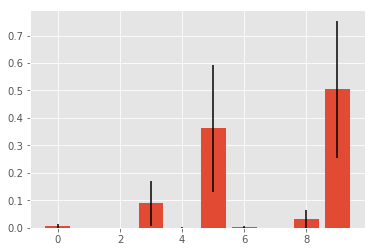

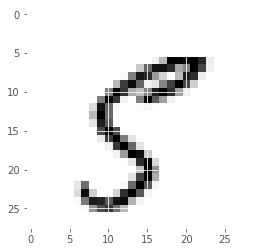

In [15]:
%matplotlib inline
index = incorrect_indices[5]
print(var[index].squeeze())
plt.bar(np.arange(10), p[index].squeeze(), yerr=var[index].squeeze())
print("Correct class: {}".format(y_test[index]))
plt.figure()
plt.imshow(mnist_test[index].reshape(28,28),cmap =plt.cm.gray_r, interpolation = "nearest") 

[5720]
[0.00166117 0.40445906 0.00144039 0.0031477  0.49812061 0.01148276
 0.0259804  0.0073625  0.00481356 0.04073322]
[0.00165841 0.24087193 0.00143832 0.00313779 0.24999647 0.0113509
 0.02530542 0.00730829 0.00479039 0.03907403]
Correct class: [4]


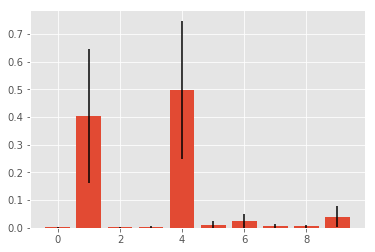

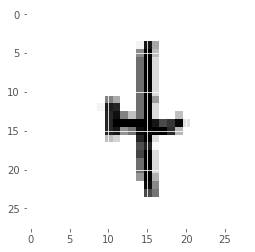

In [16]:
# %matplotlib inline
index = correct_indices[5496]
print(index)
print(p[index].squeeze())
print(var[index].squeeze())
plt.bar(np.arange(10), p[index].squeeze(), yerr=var[index].squeeze())
print("Correct class: {}".format(y_test[index]))
plt.figure()
plt.imshow(mnist_test[index].reshape(28,28),cmap =plt.cm.gray_r, interpolation = "nearest") 

## Noisy mnist

In [17]:
def load_data(DATA_DIR):
    rows, cols = 28, 28
    nb_classes = 10

    mat = scipy.io.loadmat(DATA_DIR)
    print(list(mat.keys()))
    X_train = mat['train_x']
    Y_train = np.argmax(mat['train_y'], axis=-1)
    X_test = mat['test_x']
    Y_test = np.argmax(mat['test_y'], axis=-1)
    
    # Reshape and format input
    
    #Renormalize images
    X_train = X_train.astype('float32')
    X_train /= 255.0
    X_test = X_test.astype('float32')
    X_test /= 255.0

    return (X_train, Y_train, X_test, Y_test)

(noisy_nmist_X_train, noisy_nmist_Y_train, noisy_nmist_X_test, noisy_nmist_Y_test) = load_data('data/mnist-with-awgn.mat')
(blur_nmist_X_train, blur_nmist_Y_train, blur_nmist_X_test, blur_nmist_Y_test) = load_data('data/mnist-with-motion-blur.mat')
(contrast_nmist_X_train, contrast_nmist_Y_train, contrast_nmist_X_test, contrast_nmist_Y_test) = load_data('data/mnist-with-reduced-contrast-and-awgn.mat')

['__header__', 'test_x', '__globals__', 'train_y', 'test_y', '__version__', 'train_x']
['__header__', 'test_x', '__globals__', 'train_y', 'test_y', '__version__', 'train_x']
['__header__', 'test_x', '__globals__', 'train_y', 'test_y', '__version__', 'train_x']


## Use CNN to predict noisy training examples. Note that these are unseen although called 'training'

In [18]:
import keras

In [19]:
img_rows, img_cols = 28,28

model = keras.models.load_model('my_model.h5')
cnn_noisy_predictions_probas = model.predict(noisy_nmist_X_train.reshape(-1, img_rows, img_cols, 1))
cnn_noisy_predictions = np.argmax(cnn_noisy_predictions_probas, axis=-1)

cnn_blur_predictions_probas = model.predict(blur_nmist_X_train.reshape(-1, img_rows, img_cols, 1))
cnn_blur_predictions = np.argmax(cnn_blur_predictions_probas, axis=-1)

cnn_contrast_predictions_probas = model.predict(contrast_nmist_X_train.reshape(-1, img_rows, img_cols, 1))
cnn_contrast_predictions = np.argmax(cnn_contrast_predictions_probas, axis=-1)

InvalidArgumentError: You must feed a value for placeholder tensor '0/Matern32/lengthscales/initial_unconstrained_value' with dtype double
	 [[Node: 0/Matern32/lengthscales/initial_unconstrained_value = Placeholder[dtype=DT_DOUBLE, shape=[], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op '0/Matern32/lengthscales/initial_unconstrained_value', defined at:
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-51cd3d5b44f7>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "X_train = X_train.astype('float64').reshape(-1,num_features)[:100]\ny_train = y_train.astype('float64').reshape(-1,1)[:100]\nkernel = gpflow.kernels.Matern32(num_features) + gpflow.kernels.White(num_features, variance=0.01)\nlikelihood = gpflow.likelihoods.MultiClass(num_classes)\nZ=X_train[::5].copy()\nnum_latent=num_classes\nwhiten=True\nq_diag=True\nm = gpflow.models.SVGP(X_train, y_train, \n                       kern=kernel, \n                       likelihood=likelihood,\n                       Z=Z, \n                       num_latent=num_latent,\n                       whiten=whiten, \n                       q_diag=q_diag)\n\nm.kern.white.variance.trainable = False\nm.feature.trainable = False\nm.as_pandas_table()")
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2131, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-62>", line 2, in time
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/magics/execution.py", line 1238, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 3, in <module>
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/gpflow-1.1.0-py3.5.egg/gpflow/core/compilable.py", line 90, in __init__
    self.build()
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/gpflow-1.1.0-py3.5.egg/gpflow/core/node.py", line 172, in build
    self._build()
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/gpflow-1.1.0-py3.5.egg/gpflow/params/parameterized.py", line 284, in _build
    param.build()
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/gpflow-1.1.0-py3.5.egg/gpflow/core/node.py", line 172, in build
    self._build()
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/gpflow-1.1.0-py3.5.egg/gpflow/params/parameter.py", line 345, in _build
    unconstrained = self._build_parameter()
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/gpflow-1.1.0-py3.5.egg/gpflow/params/parameter.py", line 367, in _build_parameter
    init = tf.placeholder(self.dtype, shape=shape, name='initial_unconstrained_value')
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/sebastian/anaconda/envs/python3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor '0/Matern32/lengthscales/initial_unconstrained_value' with dtype double
	 [[Node: 0/Matern32/lengthscales/initial_unconstrained_value = Placeholder[dtype=DT_DOUBLE, shape=[], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
noisy_accuracy = len(np.argwhere(cnn_noisy_predictions == noisy_nmist_Y_train))/len(noisy_nmist_Y_train)
print(noisy_accuracy)

blur_accuracy = len(np.argwhere(cnn_blur_predictions == blur_nmist_Y_train))/len(blur_nmist_Y_train)
print(blur_accuracy)

noisy_accuracy = len(np.argwhere(cnn_contrast_predictions == contrast_nmist_Y_train))/len(contrast_nmist_Y_train)
print(noisy_accuracy)

## Use GP to predict noisy training examples

In [ ]:
%%time

# noisy_X_train = get_gp_mnist_data('my_model.h5', noisy_nmist_X_train.reshape(-1, img_rows, img_cols, 1))
# blur_X_train = get_gp_mnist_data('my_model.h5', blur_nmist_X_train.reshape(-1, img_rows, img_cols, 1))
# contrast_X_train = get_gp_mnist_data('my_model.h5', contrast_nmist_X_train.reshape(-1, img_rows, img_cols, 1))

noisy_X_train = np.load('data/noisy_X_train.npy')
blur_X_train = np.load('data/blur_X_train.npy')
contrast_X_train = np.load('data/contrast_X_train.npy')


In [ ]:
noisy_X_train = noisy_X_train.astype('float64').reshape(-1,num_features)
noisy_probas, noisy_var = m.predict_y(noisy_X_train)
noisy_predictions = np.argmax(noisy_probas, axis=-1)

blur_X_train = blur_X_train.astype('float64').reshape(-1,num_features)
blur_probas, blur_var = m.predict_y(blur_X_train)
blur_predictions = np.argmax(blur_probas, axis=-1)

contrast_X_train = contrast_X_train.astype('float64').reshape(-1,num_features)
contrast_probas, contrast_var = m.predict_y(contrast_X_train)
contrast_predictions = np.argmax(contrast_probas, axis=-1)

In [ ]:
noisy_accuracy = len(np.argwhere(noisy_predictions == noisy_nmist_Y_train))/len(noisy_nmist_Y_train)
blur_accuracy = len(np.argwhere(blur_predictions == blur_nmist_Y_train))/len(blur_nmist_Y_train)
contrast_accuracy = len(np.argwhere(contrast_predictions == contrast_nmist_Y_train))/len(contrast_nmist_Y_train)
print(noisy_accuracy)
print(blur_accuracy)
print(contrast_accuracy)

In [ ]:
%matplotlib inline
def draw_img(img, axes,title=""):
    axes.imshow(img.reshape(28,28),cmap =plt.cm.gray_r) 
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(title)
    
def draw_probs(prob, var=None, axes=None):
    axes.bar(np.arange(10), prob, yerr=var)
    axes.set_ylim([0,1])
    axes.set_xticks(np.arange(10))
#     axes.set_xlabel("Digit")
    
def plot_noisy_example(img_index):
    fig = plt.figure(figsize=(12,10))

    draw_img(noisy_nmist_X_train[img_index], fig.add_subplot(3,3,1), title="White noise")
    draw_probs(noisy_probas[img_index], noisy_var[img_index], axes=fig.add_subplot(3,3,2)) 
    draw_probs(cnn_noisy_predictions_probas[img_index], axes=fig.add_subplot(3,3,3)) 

    draw_img(blur_nmist_X_train[img_index], fig.add_subplot(3,3,4), title="Motion blur")
    draw_probs(blur_probas[img_index], blur_var[img_index], axes=fig.add_subplot(3,3,5)) 
    draw_probs(cnn_blur_predictions_probas[img_index], axes=fig.add_subplot(3,3,6)) 
    
    draw_img(contrast_nmist_X_train[img_index], fig.add_subplot(3,3,7), title="White noise + reduced contrast")
    draw_probs(contrast_probas[img_index], contrast_var[img_index], fig.add_subplot(3,3,8)) 
    draw_probs(cnn_contrast_predictions_probas[img_index], axes=fig.add_subplot(3,3,9)) 
    
# img_index=1100
# plot_noisy_example(img_index)

In [ ]:
incorrect_indices = np.argwhere(noisy_predictions != noisy_nmist_Y_train)
correct_indices = np.argwhere(noisy_predictions == noisy_nmist_Y_train)
print(incorrect_indices.shape)
print(correct_indices.shape)
img_index = incorrect_indices[0][0]
print("Index: {}".format(img_index))
print("Correct class: {}".format(noisy_nmist_Y_train[img_index]))
plot_noisy_example(img_index)

Instead of accuracy use correct prediction score:
- 1 if correct prediction
- 0 if NN says "I don't know"
- -1 if incorrect

1. Eyeball
2. Invent metric
3. Embed in end-to-end system

In [39]:
fig = plt.figure(figsize=(18,8))
test_index = 18
cnn_pred = m.predict(np.array([mnist_test[test_index]]))[0]
draw_img(mnist_test[test_index], fig.add_subplot(1,1,1), title="MNIST test image")
fig.savefig("figs/mnist_test.png", bbox_inches="tight")
fig = plt.figure()
draw_probs(p[test_index], var[test_index], axes=fig.add_subplot(1,1,1)) 
fig.savefig("figs/gp_test.png", bbox_inches="tight")
fig = plt.figure()
draw_probs(cnn_pred, axes=fig.add_subplot(1,1,1)) 
fig.savefig("figs/cnn_test.png", bbox_inches="tight")

AttributeError: 'SVGP' object has no attribute 'predict'

3.25946465745429
-3.1437234354668173
[[0.05470652 0.50387217 0.01420017 0.01610646 0.04521335 0.02600623
  0.07980607 0.11502654 0.00414209 0.14013986]
 [0.0473342  0.46659441 0.0191117  0.01635278 0.04950845 0.02666697
  0.08416742 0.10239602 0.00581452 0.18127465]
 [0.0411996  0.43140947 0.02566908 0.01813896 0.05894305 0.02977837
  0.08113962 0.1046315  0.00881704 0.19948654]
 [0.03957462 0.4226856  0.02935377 0.01839392 0.05971575 0.03160338
  0.08038327 0.10734486 0.01048866 0.19966264]]


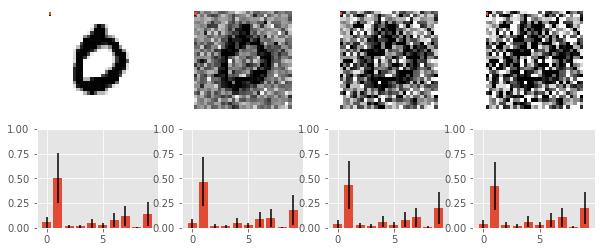

In [38]:
%matplotlib inline
index = 3
noise = np.random.randn(28, 28, 1)
# noise = np.ones(shape=(28,28,1))
# noise = noise / max(noise.max(), noise.min())
print(noise.max())
print(noise.min())
image = mnist_test[index]

num_images = 4
noisy_images = np.concatenate([np.clip(image + i/(num_images-1) * noise, -1, 1).reshape(-1, 28*28) for i in range(num_images)])
noisy_p, noisy_var = m.predict_y(noisy_images)

print(noisy_p)
fig = plt.figure(figsize=(10, 4))
for i in range(num_images):
    ax = fig.add_subplot(2,num_images, i+1)
    noisy_image = noisy_images[i]
    
    plt.bar(np.arange(10), p[index].squeeze(), yerr=var[index].squeeze())
    ax.imshow(noisy_image.reshape(28,28), cmap=plt.cm.gray_r) 
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax2 = fig.add_subplot(2,num_images,i+1+num_images)
    ax2.bar(np.arange(10), noisy_p[i].squeeze(), yerr=noisy_var[i].squeeze())
    ax2.set_ylim([0,1])
